<a href="https://colab.research.google.com/github/nsambel1980/causal_discovery/blob/main/SCUM_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Code base for SCUM forecaster, see:
 https://www.researchgate.net/publication/331075061_A_Simple_Combination_of_Univariate_Models

### SCUM Forecaster class

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import kpss
from scipy.stats import norm
import warnings
from typing import Union, Tuple, Optional, List
from dataclasses import dataclass
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

@dataclass
class ForecastResult:
    """Data class to store forecast results"""
    point_forecast: np.ndarray
    lower_pi: Optional[np.ndarray]
    upper_pi: Optional[np.ndarray]

class SCUMForecasterError(Exception):
    """Base exception class for SCUMForecaster"""
    pass

class InvalidDataError(SCUMForecasterError):
    """Exception raised for invalid input data"""
    pass

class ModelFitError(SCUMForecasterError):
    """Exception raised when model fitting fails"""
    pass

class SCUMForecaster:
    """
    Implementation of Simple Combination of Univariate Models (SCUM) method
    Combines ETS, CES, ARIMA, and DOTM models using median combination
    """

    def __init__(self, seasonal_period: Optional[int] = None):
        """
        Initialize SCUM forecaster

        Parameters:
        -----------
        seasonal_period : int, optional
            The seasonal period of the data (e.g., 12 for monthly data)

        Raises:
        -------
        ValueError
            If seasonal_period is not None and <= 1
        """
        if seasonal_period is not None and seasonal_period <= 1:
            raise ValueError("Seasonal period must be > 1")

        self.seasonal_period = seasonal_period
        self.models = {}
        self.fitted_models = {}
        self.data = None

    def _validate_data(self, data: Union[pd.Series, np.ndarray, List]) -> np.ndarray:
        """
        Validate input data and convert to numpy array

        Parameters:
        -----------
        data : array-like
            Input time series data

        Returns:
        --------
        np.ndarray
            Validated and converted data

        Raises:
        -------
        InvalidDataError
            If data is invalid
        """
        try:
            # Convert to numpy array
            if isinstance(data, pd.Series):
                data = data.values
            elif isinstance(data, list):
                data = np.array(data)

            # Check for invalid values
            if np.any(np.isnan(data)) or np.any(np.isinf(data)):
                raise InvalidDataError("Data contains NaN or infinite values")

            # Check minimum length
            if len(data) < 3:
                raise InvalidDataError("Data must have at least 3 observations")

            # Check if seasonal period is valid for data length
            if self.seasonal_period is not None and len(data) < 2 * self.seasonal_period:
                raise InvalidDataError(
                    f"Data length must be at least 2 * seasonal_period ({2 * self.seasonal_period})"
                )

            return data.astype(float)

        except Exception as e:
            if isinstance(e, InvalidDataError):
                raise
            raise InvalidDataError(f"Invalid data format: {str(e)}")

    def fit_ets(self, data: np.ndarray) -> None:
        """
        Fit ETS model using statsmodels implementation
        Similar to R's ets() but with simplified model selection

        Raises:
        -------
        ModelFitError
            If model fitting fails
        """
        try:
            model = ExponentialSmoothing(
                data,
                seasonal_periods=self.seasonal_period,
                trend='add',
                seasonal='add' if self.seasonal_period else None,
            )
            self.fitted_models['ets'] = model.fit()
        except Exception as e:
            raise ModelFitError(f"Failed to fit ETS model: {str(e)}")

    def fit_ces(self, data: np.ndarray) -> None:
        """
        Fit Complex Exponential Smoothing
        Note: This is a simplified version as the exact R implementation isn't available

        Raises:
        -------
        ModelFitError
            If model fitting fails
        """
        try:
            # For CES, we need strictly positive data
            # Add minimum value plus small constant if there are non-positive values
            if np.any(data <= 0):
                shift = abs(min(0, data.min())) + 1
                adjusted_data = data + shift
            else:
                adjusted_data = data

            model = ExponentialSmoothing(
                adjusted_data,
                seasonal_periods=self.seasonal_period,
                trend='mul',
                seasonal='mul' if self.seasonal_period else None,
            )
            fitted_model = model.fit()

            # Store both the model and the shift value for forecasting
            self.fitted_models['ces'] = {
                'model': fitted_model,
                'shift': shift if np.any(data <= 0) else 0
            }
        except Exception as e:
            raise ModelFitError(f"Failed to fit CES model: {str(e)}")

    def determine_arima_order(self, data: np.ndarray) -> Tuple[int, int, int]:
        """
        Determine ARIMA order using similar logic to auto.arima()

        Returns:
        --------
        tuple
            ARIMA order (p, d, q)

        Raises:
        -------
        ModelFitError
            If order determination fails
        """
        try:
            # Determine d using KPSS test
            kpss_stat, p_value, _, _ = kpss(data)
            d = 1 if p_value < 0.05 else 0

            # Simplified order selection
            # In practice, should implement full grid search with AICc
            return (1, d, 1)
        except Exception as e:
            raise ModelFitError(f"Failed to determine ARIMA order: {str(e)}")

    def fit_arima(self, data: np.ndarray) -> None:
        """
        Fit automatic ARIMA model
        Simplified version of auto.arima()

        Raises:
        -------
        ModelFitError
            If model fitting fails
        """
        try:
            order = self.determine_arima_order(data)
            seasonal_order = (1, 0, 1, self.seasonal_period) if self.seasonal_period else (0, 0, 0, 0)

            model = SARIMAX(
                data,
                order=order,
                seasonal_order=seasonal_order,
            )
            self.fitted_models['arima'] = model.fit(disp=False)
        except Exception as e:
            raise ModelFitError(f"Failed to fit ARIMA model: {str(e)}")

    def fit_dotm(self, data: np.ndarray) -> None:
        """
        Fit Dynamic Optimised Theta Model
        Simplified implementation of DOTM

        Raises:
        -------
        ModelFitError
            If model fitting fails
        """
        try:
            # Convert data to pandas Series for easier manipulation
            series = pd.Series(data)

            # Implement seasonal decomposition if needed
            if self.seasonal_period:
                # Calculate seasonal indices
                decomposition = pd.DataFrame(series).rolling(
                    window=self.seasonal_period,
                    center=True,
                    min_periods=1  # Allow partial windows
                ).mean()
                data_adjusted = series / decomposition[0].fillna(1)
            else:
                data_adjusted = series

            # Simplified theta model implementation
            # Store both the original data and the adjustment factors
            self.fitted_models['dotm'] = {
                'data': data_adjusted,
                'seasonal_factors': decomposition[0].fillna(1) if self.seasonal_period else None,
                'last_value': data_adjusted.iloc[-1]
            }
        except Exception as e:
            raise ModelFitError(f"Failed to fit DOTM model: {str(e)}")

    def fit(self, data: Union[pd.Series, np.ndarray, List]) -> 'SCUMForecaster':
        """
        Fit all models

        Parameters:
        -----------
        data : array-like
            Input time series data

        Returns:
        --------
        self : SCUMForecaster
            Fitted forecaster object

        Raises:
        -------
        InvalidDataError
            If data is invalid
        ModelFitError
            If any model fitting fails
        """
        self.data = self._validate_data(data)

        # Fit all models
        self.fit_ets(self.data)
        self.fit_ces(self.data)
        self.fit_arima(self.data)
        self.fit_dotm(self.data)

        return self

    def forecast(self, steps: int) -> ForecastResult:
        """
        Generate forecasts using median combination

        Parameters:
        -----------
        steps : int
            Number of steps to forecast ahead

        Returns:
        --------
        ForecastResult
            Object containing point forecasts and prediction intervals

        Raises:
        -------
        ValueError
            If steps is invalid
        SCUMForecasterError
            If forecasting fails
        """
        if not isinstance(steps, int) or steps < 1:
            raise ValueError("steps must be a positive integer")

        if not self.fitted_models:
            raise SCUMForecasterError("Models must be fitted before forecasting")

        try:
            forecasts = []
            lower_intervals = []
            upper_intervals = []

            # Generate forecasts from each model
            for model_name, fitted_model in self.fitted_models.items():
                if model_name == 'ets':
                    forecast = fitted_model.forecast(steps)
                    forecasts.append(forecast)
                    # For ETS, use forecast standard errors
                    try:
                        std_errors = np.sqrt(fitted_model.mse) * np.sqrt(np.arange(1, steps + 1))
                        lower_intervals.append(forecast - 1.96 * std_errors)
                        upper_intervals.append(forecast + 1.96 * std_errors)
                    except:
                        pass

                elif model_name == 'ces':
                    # Get forecast and adjust back by shift value
                    forecast = fitted_model['model'].forecast(steps)
                    forecast = forecast - fitted_model['shift']
                    forecasts.append(forecast)
                    # For CES, use similar approach as ETS
                    try:
                        std_errors = np.sqrt(fitted_model['model'].mse) * np.sqrt(np.arange(1, steps + 1))
                        lower_intervals.append(forecast - 1.96 * std_errors)
                        upper_intervals.append(forecast + 1.96 * std_errors)
                    except:
                        pass

                elif model_name == 'arima':
                    forecast = fitted_model.forecast(steps)
                    pred_int = fitted_model.get_forecast(steps)
                    forecasts.append(forecast)
                    try:
                        conf_int = pred_int.conf_int()
                        lower_intervals.append(conf_int.iloc[:, 0])
                        upper_intervals.append(conf_int.iloc[:, 1])
                    except:
                        pass

                else:  # dotm
                    # Generate DOTM forecasts
                    base_forecast = np.ones(steps) * fitted_model['last_value']

                    if fitted_model['seasonal_factors'] is not None:
                        # Repeat seasonal factors for the forecast horizon
                        last_idx = len(fitted_model['data'])
                        seasonal_idxs = np.arange(last_idx, last_idx + steps) % self.seasonal_period
                        seasonal_factors = fitted_model['seasonal_factors'].iloc[seasonal_idxs].values
                        forecast = base_forecast * seasonal_factors
                    else:
                        forecast = base_forecast

                    forecasts.append(forecast)

            # Combine forecasts using median
            point_forecast = np.median(forecasts, axis=0)

            # Combine prediction intervals using median
            lower_pi = np.median(lower_intervals, axis=0) if lower_intervals else None
            upper_pi = np.median(upper_intervals, axis=0) if upper_intervals else None

            return ForecastResult(point_forecast, lower_pi, upper_pi)

        except Exception as e:
            raise SCUMForecasterError(f"Forecasting failed: {str(e)}")


### Helper functions for synthetic data generation and plotting

In [5]:
def generate_synthetic_data(n_periods: int, seasonal_period: int = 12, positive: bool = True) -> np.ndarray:
    """
    Generate synthetic time series data with trend, seasonality, and noise

    Parameters:
    -----------
    n_periods : int
        Number of time periods to generate
    seasonal_period : int
        Length of seasonal cycle (default=12 for monthly data)
    positive : bool
        If True, ensure all values are positive by adding an offset

    Returns:
    --------
    np.ndarray
        Synthetic time series data
    """
    t = np.arange(n_periods)
    trend = 0.1 * t
    seasonality = 10 * np.sin(2 * np.pi * t / seasonal_period)
    noise = np.random.normal(0, 1, n_periods)
    data = trend + seasonality + noise

    if positive:
        # Ensure all values are positive
        if data.min() <= 0:
            data = data - data.min() + 1

    return data

def plot_forecast_results(data: np.ndarray, individual_forecasts: dict, individual_intervals: dict,
                         combined_result: ForecastResult, title: str = 'SCUM Forecast Example') -> None:
    """
    Plot historical data, individual forecasts, and combined SCUM forecast

    Parameters:
    -----------
    data : np.ndarray
        Historical data
    individual_forecasts : dict
        Dictionary of individual model forecasts
    individual_intervals : dict
        Dictionary of individual model prediction intervals
    combined_result : ForecastResult
        Combined SCUM forecast results
    title : str
        Plot title
    """
    plt.figure(figsize=(12, 6))

    # Plot historical data
    t = np.arange(len(data))
    plt.plot(t, data, label='Historical Data', color='gray', alpha=0.5)

    # Colors for different models
    colors = {
        'ets': 'blue',
        'ces': 'green',
        'arima': 'red',
        'dotm': 'purple',
        'scum': 'black'
    }

    # Plot individual forecasts
    forecast_t = len(t)
    for model, forecast in individual_forecasts.items():
        if forecast is not None:
            plt.plot(forecast_t, forecast[0], 'o',
                    label=f'{model.upper()} Forecast',
                    color=colors[model])

            # Plot individual prediction intervals
            lower, upper = individual_intervals[model]
            if lower is not None and upper is not None:
                plt.vlines(forecast_t, lower[0], upper[0],
                          color=colors[model], alpha=0.3)

    # Plot SCUM forecast
    plt.plot(forecast_t, combined_result.point_forecast[0], 'o',
             label='SCUM Forecast', color=colors['scum'], markersize=10)

    # Plot SCUM prediction intervals if available
    if combined_result.lower_pi is not None and combined_result.upper_pi is not None:
        plt.vlines(forecast_t,
                  combined_result.lower_pi[0],
                  combined_result.upper_pi[0],
                  color=colors['scum'], linewidth=2, alpha=0.5)

    plt.title(title)
    plt.xlabel('Time Period')
    plt.ylabel('Value')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def get_model_forecasts(forecaster: SCUMForecaster, data: np.ndarray, steps: int = 1):
    """Get individual forecasts for each model"""
    forecasts = {}
    intervals = {}

    for model_name, fitted_model in forecaster.fitted_models.items():
        try:
            if model_name == 'ets':
                forecast = fitted_model.forecast(steps)
                # Use prediction intervals based on SSE
                sse = sum((fitted_model.resid) ** 2)
                nobs = len(fitted_model.resid)
                sigma = np.sqrt(sse / (nobs - 2))  # -2 for trend and level
                lower = forecast - 1.96 * sigma
                upper = forecast + 1.96 * sigma

            elif model_name == 'ces':
                forecast = fitted_model['model'].forecast(steps)
                forecast = forecast - fitted_model['shift']
                # Use prediction intervals based on SSE
                sse = sum((fitted_model['model'].resid) ** 2)
                nobs = len(fitted_model['model'].resid)
                sigma = np.sqrt(sse / (nobs - 2))
                lower = forecast - 1.96 * sigma
                upper = forecast + 1.96 * sigma

            elif model_name == 'arima':
                forecast = fitted_model.forecast(steps)
                pred_int = fitted_model.get_forecast(steps)
                conf_int = pred_int.conf_int()
                if isinstance(conf_int, pd.DataFrame):
                    lower = conf_int.iloc[:, 0].values
                    upper = conf_int.iloc[:, 1].values
                else:
                    lower = conf_int[:, 0]
                    upper = conf_int[:, 1]

            else:  # dotm
                forecast = np.ones(steps) * fitted_model['last_value']
                if fitted_model['seasonal_factors'] is not None:
                    last_idx = len(fitted_model['data'])
                    seasonal_idxs = np.arange(last_idx, last_idx + steps) % forecaster.seasonal_period
                    seasonal_factors = fitted_model['seasonal_factors'].iloc[seasonal_idxs].values
                    forecast = forecast * seasonal_factors
                # Simple prediction intervals based on historical std dev
                historical_std = fitted_model['data'].std()
                lower = forecast - 1.96 * historical_std
                upper = forecast + 1.96 * historical_std

            # Convert everything to numpy arrays
            if not isinstance(forecast, np.ndarray):
                forecast = np.array(forecast)
            if not isinstance(lower, np.ndarray):
                lower = np.array(lower)
            if not isinstance(upper, np.ndarray):
                upper = np.array(upper)

            forecasts[model_name] = forecast
            intervals[model_name] = (lower, upper)

        except Exception as e:
            print(f"Warning: Could not generate forecast for {model_name}: {str(e)}")
            forecasts[model_name] = None
            intervals[model_name] = (None, None)

    return forecasts, intervals

def run_seasonal_example() -> None:
    """Run example with seasonal data"""
    try:
        # Generate synthetic seasonal data (ensuring positive values)
        np.random.seed(42)  # For reproducibility
        data = generate_synthetic_data(n_periods=96, positive=True)  # 4 years of monthly data

        # Initialize and fit forecaster
        forecaster = SCUMForecaster(seasonal_period=12)
        forecaster.fit(data)

        # Generate individual and combined forecasts
        individual_forecasts, individual_intervals = get_model_forecasts(forecaster, data, steps=1)
        combined_result = forecaster.forecast(steps=1)

        # Print results
        print("\nSeasonal Example Results (h=1):")
        print("-" * 50)
        print("Individual Model Forecasts:")
        for model in ['ets', 'ces', 'arima', 'dotm']:
            if individual_forecasts[model] is not None:
                forecast = individual_forecasts[model][0]  # First value for h=1
                lower, upper = individual_intervals[model]
                if lower is not None:
                    print(f"{model.upper()}: {forecast:.3f} [{lower[0]:.3f}, {upper[0]:.3f}]")
                else:
                    print(f"{model.upper()}: {forecast:.3f} [No PI available]")

        print("\nCombined SCUM Forecast:")
        if combined_result.lower_pi is not None:
            print(f"SCUM: {combined_result.point_forecast[0]:.3f} [{combined_result.lower_pi[0]:.3f}, {combined_result.upper_pi[0]:.3f}]")
        else:
            print(f"SCUM: {combined_result.point_forecast[0]:.3f} [No PI available]")

        # Plot results
        plot_forecast_results(data,individual_forecasts, individual_intervals, combined_result)

    except (InvalidDataError, ModelFitError, SCUMForecasterError) as e:
        print(f"Error in seasonal example: {str(e)}")
    except Exception as e:
        print(f"Unexpected error in seasonal example: {str(e)}")

def run_nonseasonal_example() -> None:
    """Run example with non-seasonal data"""
    try:
        # Generate random walk data
        np.random.seed(45)
        random_walk = np.cumsum(np.random.normal(0, 1, 100))

        # Initialize and fit forecaster
        forecaster = SCUMForecaster(seasonal_period=None)
        forecaster.fit(random_walk)

        # Generate individual and combined forecasts
        individual_forecasts, individual_intervals = get_model_forecasts(forecaster, random_walk, steps=1)
        combined_result = forecaster.forecast(steps=1)

        # Print results
        print("\nNon-seasonal Example Results (h=1):")
        print("-" * 50)
        print("Individual Model Forecasts:")
        for model in ['ets', 'ces', 'arima', 'dotm']:
            if individual_forecasts[model] is not None:
                forecast = individual_forecasts[model][0]  # First value for h=1
                lower, upper = individual_intervals[model]
                if lower is not None:
                    print(f"{model.upper()}: {forecast:.3f} [{lower[0]:.3f}, {upper[0]:.3f}]")
                else:
                    print(f"{model.upper()}: {forecast:.3f} [No PI available]")

        print("\nCombined SCUM Forecast:")
        if combined_result.lower_pi is not None:
            print(f"SCUM: {combined_result.point_forecast[0]:.3f} [{combined_result.lower_pi[0]:.3f}, {combined_result.upper_pi[0]:.3f}]")
        else:
            print(f"SCUM: {combined_result.point_forecast[0]:.3f} [No PI available]")

        # Plot results
        plot_forecast_results(random_walk,individual_forecasts, individual_intervals, combined_result,
                            title='SCUM Forecast - Non-seasonal Data')

    except (InvalidDataError, ModelFitError, SCUMForecasterError) as e:
        print(f"Error in non-seasonal example: {str(e)}")
    except Exception as e:
        print(f"Unexpected error in non-seasonal example: {str(e)}")

### Seasonal and non-seasonal examples

Running SCUM Forecasting Examples
--------------------------------------------------

1. Seasonal Data Example

Seasonal Example Results (h=1):
--------------------------------------------------
Individual Model Forecasts:
ETS: 18.940 [17.168, 20.713]
CES: 18.123 [15.555, 20.690]
ARIMA: 18.225 [16.080, 20.370]
DOTM: 14.776 [13.782, 15.769]

Combined SCUM Forecast:
SCUM: 18.174 [No PI available]


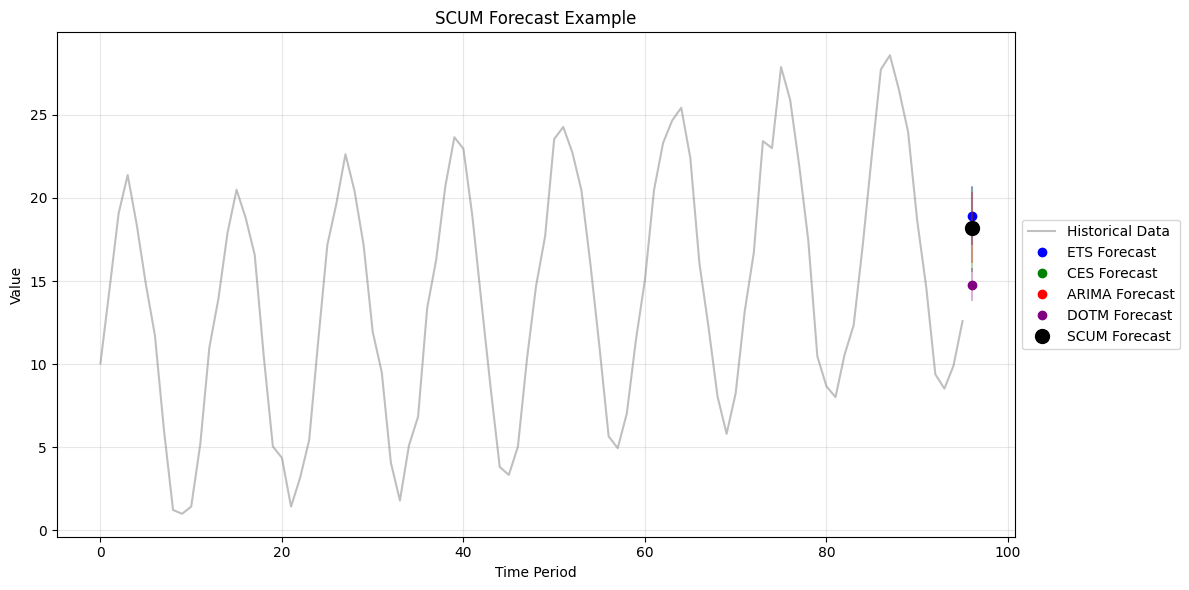


2. Non-seasonal Data Example

Non-seasonal Example Results (h=1):
--------------------------------------------------
Individual Model Forecasts:
ETS: -14.123 [-15.962, -12.284]
CES: -14.042 [-15.836, -12.248]
ARIMA: -14.005 [-15.851, -12.158]
DOTM: -13.918 [-21.408, -6.428]

Combined SCUM Forecast:
SCUM: -14.023 [No PI available]


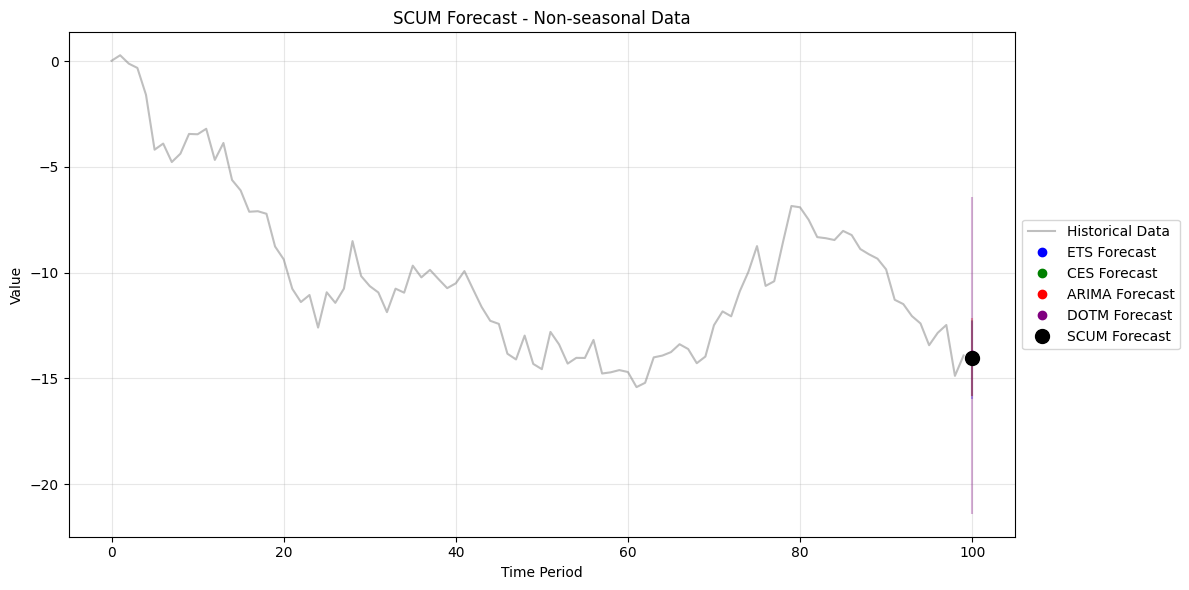

In [7]:
def main():
    """Main function to run SCUM forecasting examples"""
    print("Running SCUM Forecasting Examples")
    print("-" * 50)
    print("\n1. Seasonal Data Example")
    run_seasonal_example()
    print("\n2. Non-seasonal Data Example")
    run_nonseasonal_example()

main()